## Imports

In [1]:
import torch
import torch.utils.data as data_utils
from torchvision import transforms
import pandas as pd
import numpy as np
from torchsummary import summary
import os
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optimdata_utils
from datetime import datetime
import random
from nn_class_definitions import *
import matplotlib.pyplot as plt
from reshape_dataset import reshape_tensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



torch.cuda.empty_cache()
DATASET_FOLDER = "/home/lorenzo/Datasets/gallery_detection/laserscan_image_polished"
PATH_TO_MODEL = "/home/lorenzo/catkin_ws/data/trained_nets/gallery_detection_nets/laserscan_image_based/gallery_detector_v3_loss_MSELoasdfss_lr_0.0005_N_16__"
UPDATE_MODEL = False
NET = lets_get_chonky_2


cuda:0


In [2]:
net = NET().to(device)
summary(net,(1,16,360))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 14, 360]             184
       BatchNorm2d-2           [-1, 4, 14, 360]               8
              ReLU-3           [-1, 4, 14, 360]               0
            Conv2d-4           [-1, 8, 12, 360]           1,448
       BatchNorm2d-5           [-1, 8, 12, 360]              16
              ReLU-6           [-1, 8, 12, 360]               0
            Conv2d-7          [-1, 16, 10, 360]           5,776
       BatchNorm2d-8          [-1, 16, 10, 360]              32
              ReLU-9          [-1, 16, 10, 360]               0
           Conv2d-10           [-1, 32, 8, 360]          23,072
      BatchNorm2d-11           [-1, 32, 8, 360]              64
             ReLU-12           [-1, 32, 8, 360]               0
           Conv2d-13           [-1, 16, 6, 360]          23,056
      BatchNorm2d-14           [-1, 16,

## Data

### Defs

In [4]:
import numpy as np
from scipy.stats import norm
import torch


def gen_normal_distribution( n_elements):
    nd = norm(loc=2, scale=0.5)
    n = 0
    array = []
    for i in np.arange(0, 4, 4/n_elements):
        if n == n_elements:
            break
        n += 1
        array.append(nd.pdf(i))

    return array
aperture = 60
normal_array = gen_normal_distribution(aperture)
def reshape_tensor(tensor):

    
    centers = (tensor >= 0.99*torch.max(tensor)).nonzero()
    tensor = tensor * 0
    centers = centers.cpu().detach().numpy()
    for center in centers:
        for i in range(aperture):
            index = int(center - aperture/2 + i) % 360

            tensor[index] = normal_array[i]
    return tensor

In [5]:
class ImageDataset(data_utils.Dataset):
    def __init__(self, path_to_dataset=None,do_augment=True):
        self.do_augment=do_augment
        self.transforms = transforms.RandomApply(torch.nn.ModuleList([
            transforms.RandomRotation((-2,2), expand=False, center=None, fill=0, resample=None),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.05), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.05), ratio=(0.5, 1), value=0, inplace=False)
            ]), p=1)

        self.horizontal_flip = transforms.RandomHorizontalFlip(p=1)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if path_to_dataset != None:
            self.load_dataset(path_to_dataset)

    def load_dataset(self, dataset_folder):
        self.folder = dataset_folder
        self.dir_elements = os.listdir(dataset_folder)
        self.len = self.dir_elements.__len__()
        for idx in range(self.len):
            print("\r",end="")
            print(idx,end="")
            img_path = os.path.join(self.folder, "{}.pt".format(idx))
            x, y = torch.load(img_path)
            if idx == 0:
                s = x.shape
                self.new_image_shape = (1,s[0],s[1])
                self.images = torch.zeros((self.len,1,s[0],s[1])).float()
                s = y.shape
                self.labels = torch.zeros((self.len,s[0])).float()

            x = torch.reshape(x,self.new_image_shape)
            self.images[idx,...] = x
            self.labels[idx,...] = y

    def save(self, save_folder):
        for idx, (x,y) in enumerate(self):
            x = torch.tensor(x.detach().cpu().numpy()[0,...])
            y = torch.tensor(y.detach().cpu().numpy())
            element_path = os.path.join(save_folder, "{}.pt".format(idx))
            tupla = (x,y)
            torch.save(tupla,element_path)
            print("\r",end="")
            print(idx,end="")


    def update_labels(self):
        for idx in range(self.__len__()):
            print("\r",end="")
            print(idx,end="")
            self.labels[idx,...] = reshape_tensor(self.labels[idx,...])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image = self.images[idx,...].float()
        result = self.labels[idx,...]

        if self.do_augment:
            image, result = self.augment(image, result)

        return image.float(), result

    def augment(self, image, result):
        # HORIZONTAL FLIP
        if random.randint(0,100) < 20:
            image = self.horizontal_flip(image)
            result = self.horizontal_flip(torch.reshape(result,(1,-1))).flatten()

        # HORIZONTAL SHIFT
        n = random.randint(-20,20)
        image = torch.roll(image,n,dims=2)
        result = torch.roll(result,n)

        # VERTICAL SHIFT
        n = random.randint(-2,2)
        image = torch.roll(image,n,dims=0)

        # GAUSSIAN NOISE
        image += np.random.normal(0, random.uniform(0,0.02), (16,360)).astype(float)
        image /= torch.max(image)
        image[image<0] = 0

        # TORCH DATA AUG
        image = self.transforms(image)

        return image, result

    def show(self, idx):
        
        x, y = self.__getitem__(idx)
        image = x.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        fig, axs = plt.subplots(2)
        axs[0].imshow(image[0,...])
        axs[1].plot(y)
        axs[1].set_xlim([0,359])
        plt.show()

    def show_range(self, i1, i2):
        fig, axs = plt.subplots(2)
        for i in range(i1,i2):
            x, y = self.images[i,...], self.labels[i,...]
            image = x.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            axs[0].imshow(image[0,...])
            axs[1].plot(y)
            axs[1].set_xlim([0,359])
            plt.draw()



In [6]:
DATASET_FOLDER = "/home/lorenzo/Datasets/gallery_detection/laserscan_image_polished"
dataset = ImageDataset(path_to_dataset=DATASET_FOLDER,do_augment=False)
i = 0



89729

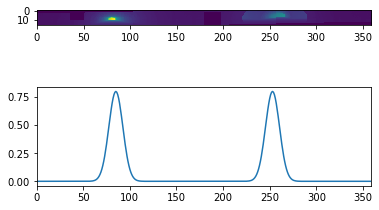

In [42]:
dataset.do_augment = True
dataset.show(i)
i+=1

Text(0.5, 0, '$\\theta$ (deg)')

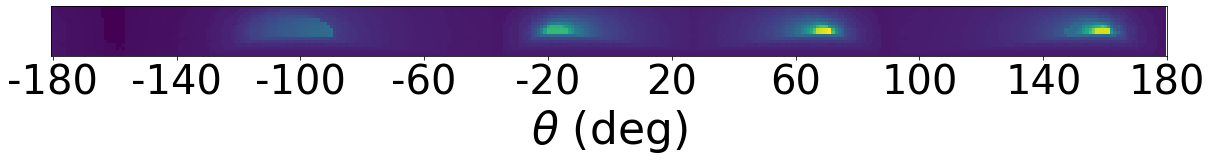

In [23]:
fontsize=40
x, y = dataset.__getitem__(i)
image = x.cpu().detach().numpy()

fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(image[0,...])
plt.gca().set_yticks(range(16,-16))
plt.xticks(ticks=np.arange(0,361, step=40),labels=np.arange(-180,181, step=40),fontsize=fontsize)
# axs[0].set_title("Depth image",fontsize=fontsize*1.5)
plt.xlabel(r"$\theta$ (deg)",fontsize=fontsize*1.1)



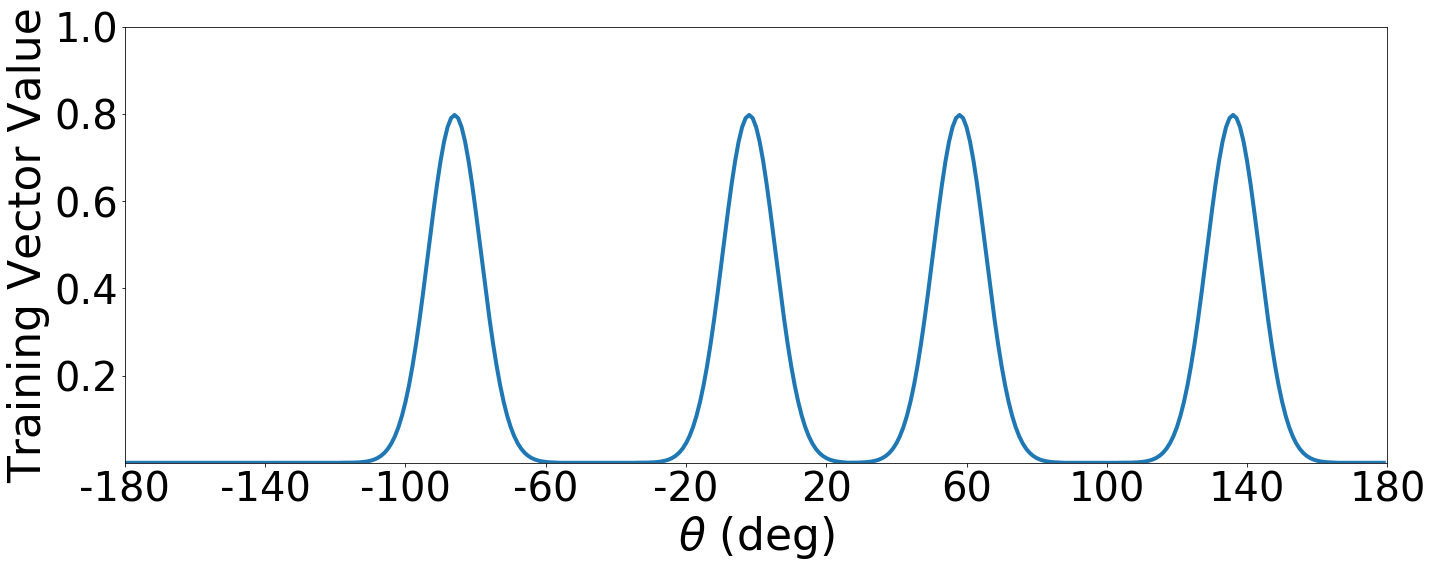

In [25]:
x, y = dataset.__getitem__(i)
fig = plt.figure()
fig.set_size_inches(20, 8)
y = reshape_tensor(y)
y = y.cpu().detach().numpy()
plt.plot(y,linewidth=4)
plt.gca().set_xlim([0,359])
plt.gca().set_ylim([0,1])
plt.xticks(ticks=np.arange(0,361, step=40),labels=np.arange(-180,181, step=40),fontsize=fontsize)
plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0],fontsize=fontsize)
# axs[1].set_title("Gallery Detection Vector",fontsize=fontsize*1.5)
plt.xlabel(r"$\theta$ (deg)",fontsize=fontsize*1.1)
plt.ylabel("Training Vector Value",fontsize=fontsize*1.1)
plt.tight_layout()
plt.show()


In [43]:

train_len = int(dataset.__len__() * 0.9)
test_len = int(dataset.__len__() - train_len)

train_dataset, test_dataset = data_utils.random_split(dataset,[train_len, test_len])

In [44]:
i = 0  
train_dataset.transforms = transforms.RandomApply(torch.nn.ModuleList([
            transforms.RandomRotation((-2,2), expand=False, center=None, fill=0, resample=None),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False),
            transforms.RandomErasing(p=0.5, scale=(0.0, 0.01), ratio=(0.5, 1), value=0, inplace=False)
            ]), p=0.5)
dataset.transforms = train_dataset.transforms

## Train

### Definitions

In [45]:
def basic_train(network, train_loader, criterion, optimizer, n_epochs):
    loss = 1
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        loss_history = []
        print("",end="\r")
        print("Epoch {} out of {}: loss {}".format(epoch + 1, n_epochs, loss),end="")
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            print("",end="\r")
            print(f"{i}",end="")
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss_history.append(loss.item())
            loss.backward()
            optimizer.step()

        plt.plot(loss_history)
        plt.show()
    
    return loss_history

### Run Training

In [48]:
class lets_get_chonky_2(nn.Module):
    """Detecta entre recta e intersección a 4"""
    def __init__(self):
        super(lets_get_chonky_2, self).__init__()

        kernel_widht = 21
        padding = int(kernel_widht / 2)

        self.layers = nn.Sequential(
            nn.Conv2d(1,4,[3,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.Conv2d(4,8,[3,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8,16,[3,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16,32,[3,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,64,[3,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,128,[3,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(128),
            nn.ReLU(),


            nn.Conv2d(128,64,[3,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,32,[1,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32,16,[1,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16,8,[1,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8,1,[1,kernel_widht],padding=(0,padding),padding_mode="circular"),
            nn.ReLU(),
            nn.AvgPool2d([2,1]),
            nn.Flatten(),

            nn.Linear(360,720),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(720,360),
            nn.Dropout(0.2),
            nn.ReLU()

        )
    @classmethod
    def is_2d(cls):
        return False

    def forward(self, x):
        # X should be an image with floats from 0 to 1
        logits = self.layers(x)
        return logits
NET = lets_get_chonky_2

In [49]:
summary(NET().to(device),(1,16,360))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 4, 14, 360]             256
       BatchNorm2d-2           [-1, 4, 14, 360]               8
              ReLU-3           [-1, 4, 14, 360]               0
            Conv2d-4           [-1, 8, 12, 360]           2,024
       BatchNorm2d-5           [-1, 8, 12, 360]              16
              ReLU-6           [-1, 8, 12, 360]               0
            Conv2d-7          [-1, 16, 10, 360]           8,080
       BatchNorm2d-8          [-1, 16, 10, 360]              32
              ReLU-9          [-1, 16, 10, 360]               0
           Conv2d-10           [-1, 32, 8, 360]          32,288
      BatchNorm2d-11           [-1, 32, 8, 360]              64
             ReLU-12           [-1, 32, 8, 360]               0
           Conv2d-13           [-1, 64, 6, 360]         129,088
      BatchNorm2d-14           [-1, 64,

type: lets_get_chonky_2, loss: MSELoss, lr: 0.0002
157ch 1 out of 32: loss 1

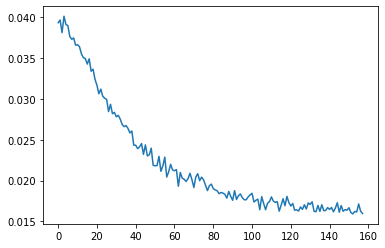

157ch 2 out of 32: loss 0.015968238934874535

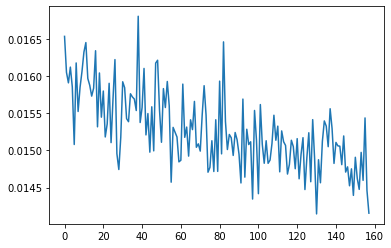

157ch 3 out of 32: loss 0.014155523851513863

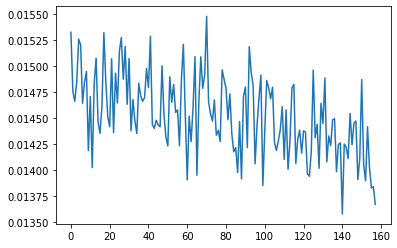

157ch 4 out of 32: loss 0.013670781627297401

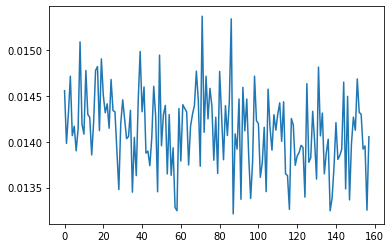

157ch 5 out of 32: loss 0.014056013897061348

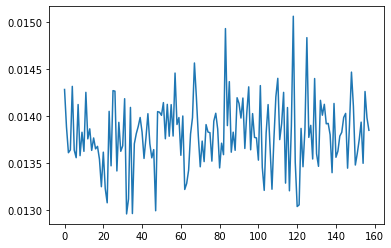

157ch 6 out of 32: loss 0.013849516399204731

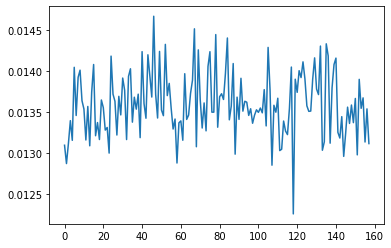

157ch 7 out of 32: loss 0.013115539215505123

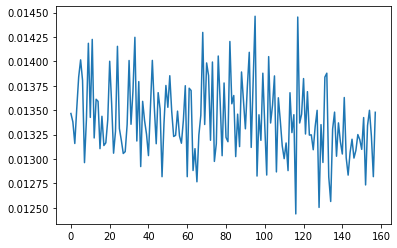

157ch 8 out of 32: loss 0.013477747328579426

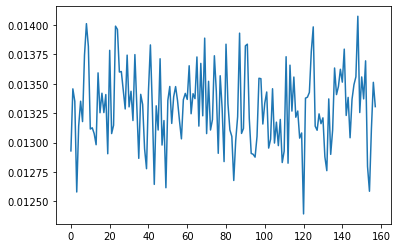

157ch 9 out of 32: loss 0.013305463828146458

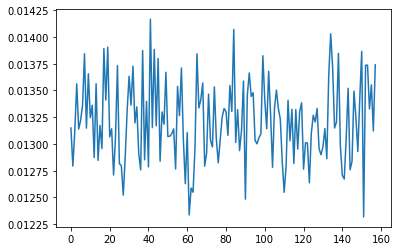

157ch 10 out of 32: loss 0.013739784248173237

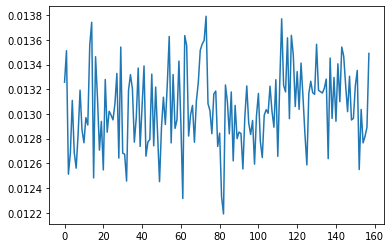

157ch 11 out of 32: loss 0.013490535318851471

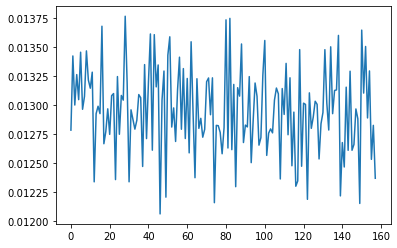

157ch 12 out of 32: loss 0.012369006872177124

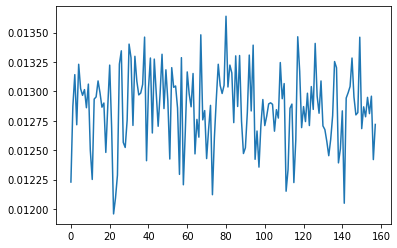

157ch 13 out of 32: loss 0.012718654237687588

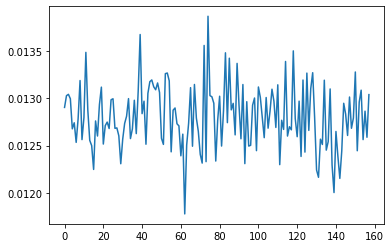

157ch 14 out of 32: loss 0.013039911165833473

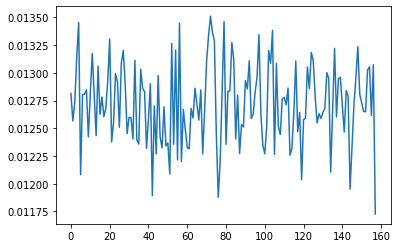

157ch 15 out of 32: loss 0.011727712117135525

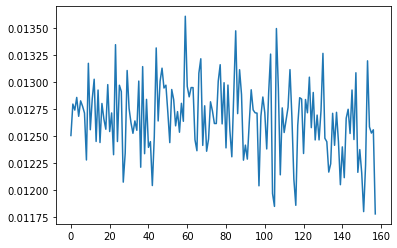

157ch 16 out of 32: loss 0.011781138367950916

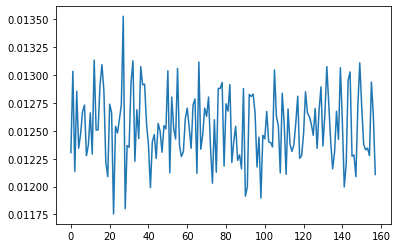

157ch 17 out of 32: loss 0.012108330614864826

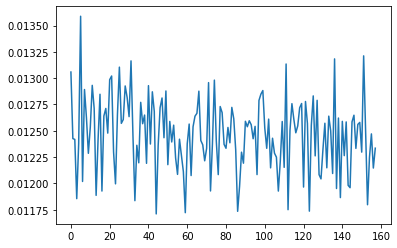

157ch 18 out of 32: loss 0.012335079722106457

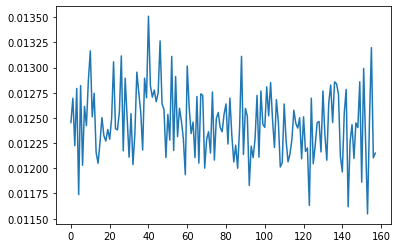

157ch 19 out of 32: loss 0.012150578200817108

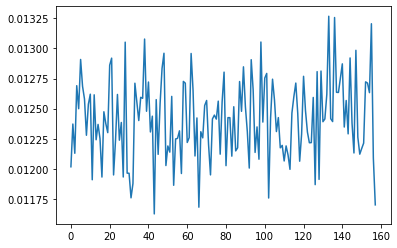

157ch 20 out of 32: loss 0.011701828800141811

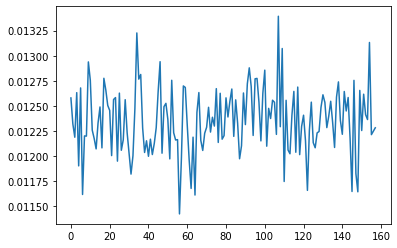

157ch 21 out of 32: loss 0.012281210161745548

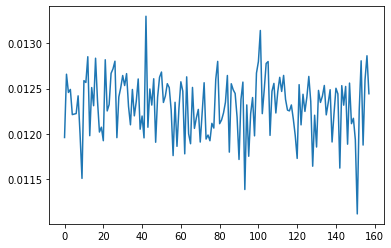

157ch 22 out of 32: loss 0.01244308240711689

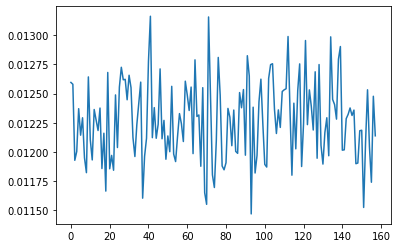

157ch 23 out of 32: loss 0.012138444930315018

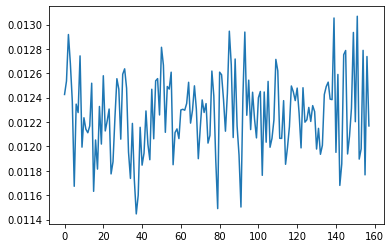

157ch 24 out of 32: loss 0.012167858891189098

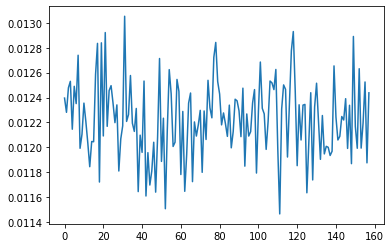

157ch 25 out of 32: loss 0.012437975034117699

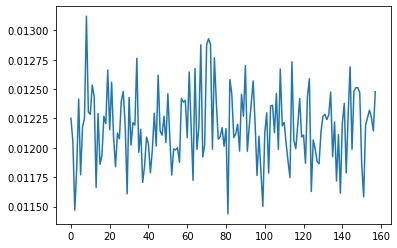

157ch 26 out of 32: loss 0.012477627955377102

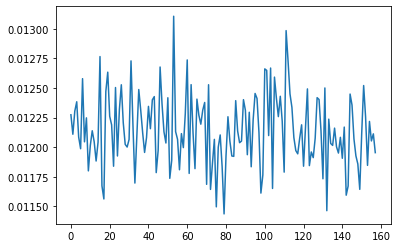

157ch 27 out of 32: loss 0.01195356622338295

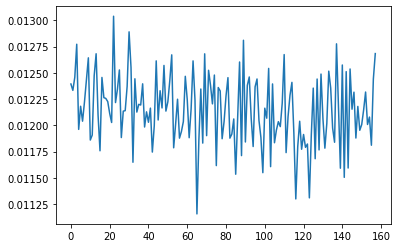

157ch 28 out of 32: loss 0.01268343161791563

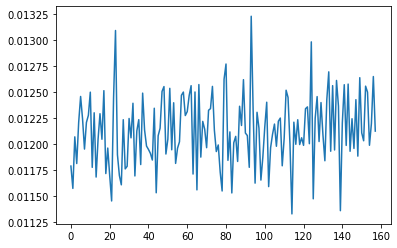

157ch 29 out of 32: loss 0.01212400384247303

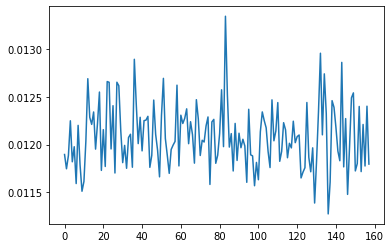

157ch 30 out of 32: loss 0.011795973405241966

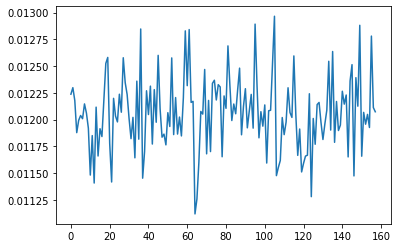

157ch 31 out of 32: loss 0.012073476798832417

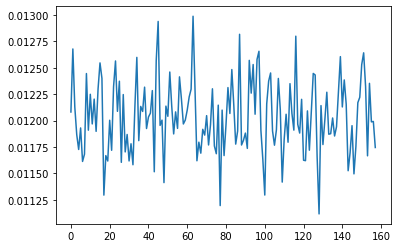

157ch 32 out of 32: loss 0.011744742281734943

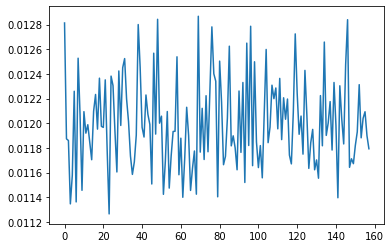

/home/lorenzo/catkin_ws/data/trained_nets/gallery_detection_nets/laserscan_image_based/lets_get_chonky_2_losss_MSELoss_lr_0.0002_N_32_small
type: lets_get_chonky_2, loss: MSELoss, lr: 0.0001
157ch 1 out of 32: loss 1

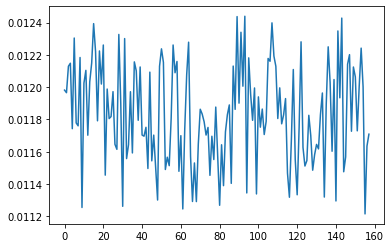

157ch 2 out of 32: loss 0.011708732694387436

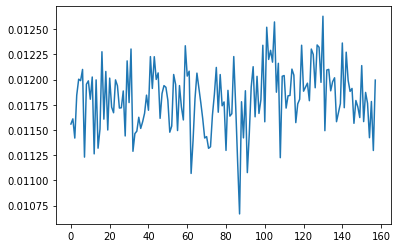

157ch 3 out of 32: loss 0.01199415698647499

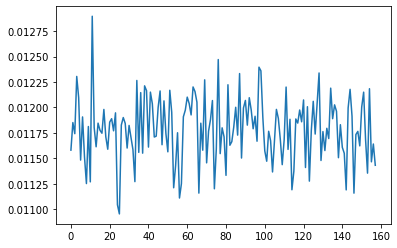

157ch 4 out of 32: loss 0.011431297287344933

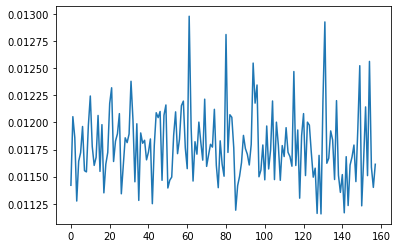

157ch 5 out of 32: loss 0.011613992042839527

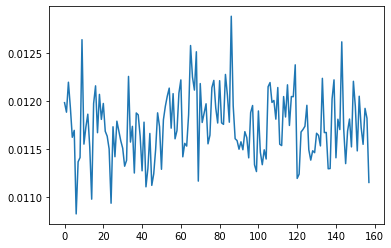

157ch 6 out of 32: loss 0.011155029758810997

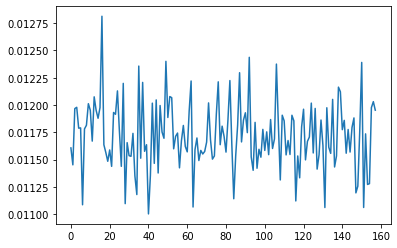

157ch 7 out of 32: loss 0.011952124536037445

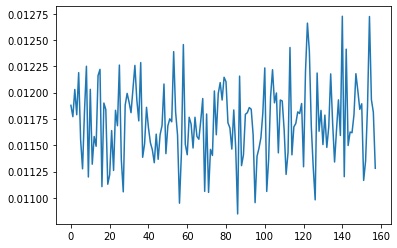

157ch 8 out of 32: loss 0.011280510574579239

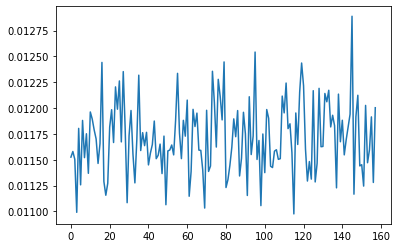

157ch 9 out of 32: loss 0.012003680691123009

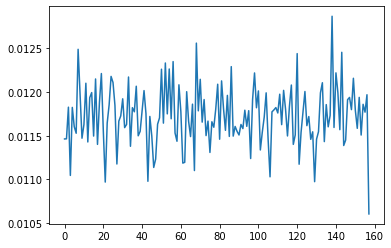

157ch 10 out of 32: loss 0.010605035349726677

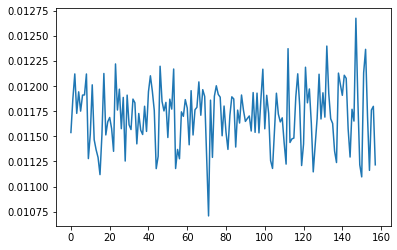

157ch 11 out of 32: loss 0.011216065846383572

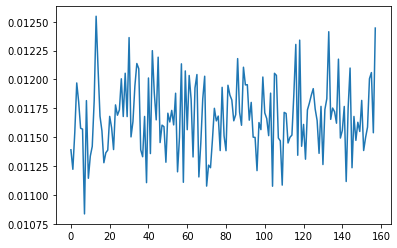

157ch 12 out of 32: loss 0.012444764375686646

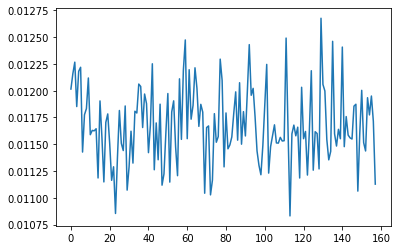

157ch 13 out of 32: loss 0.011127674020826817

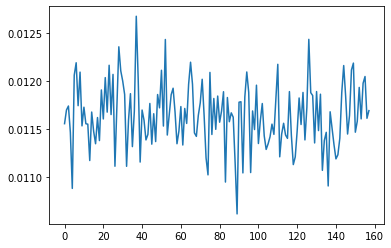

157ch 14 out of 32: loss 0.011689399369060993

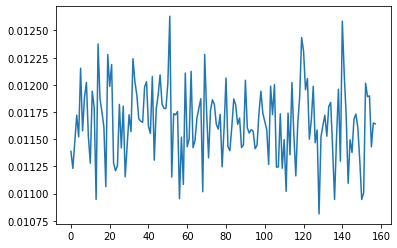

157ch 15 out of 32: loss 0.011641375720500946

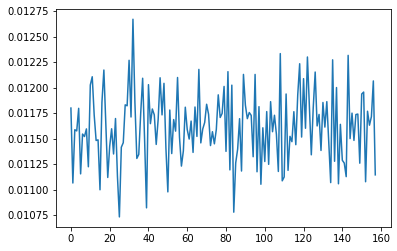

157ch 16 out of 32: loss 0.011144623160362244

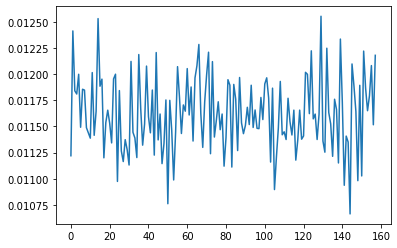

157ch 17 out of 32: loss 0.012181062251329422

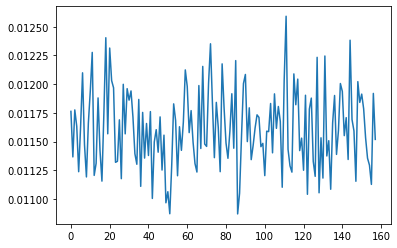

157ch 18 out of 32: loss 0.011519178748130798

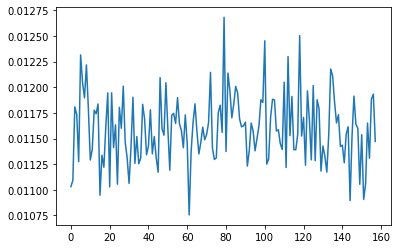

157ch 19 out of 32: loss 0.011471598409116268

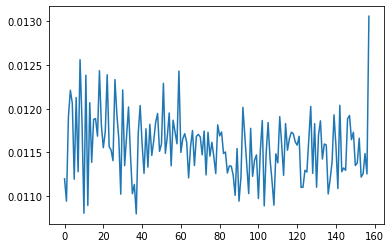

157ch 20 out of 32: loss 0.013059821911156178

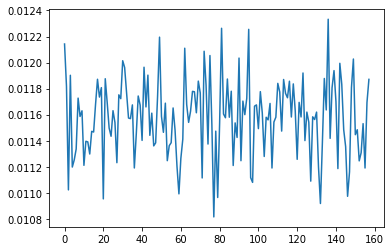

157ch 21 out of 32: loss 0.011871051043272018

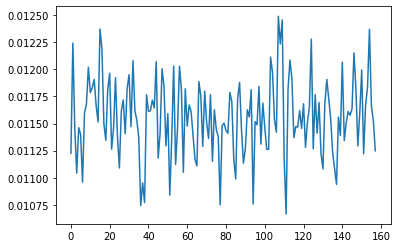

157ch 22 out of 32: loss 0.011247607879340649

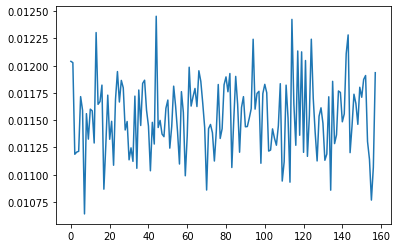

157ch 23 out of 32: loss 0.011935889720916748

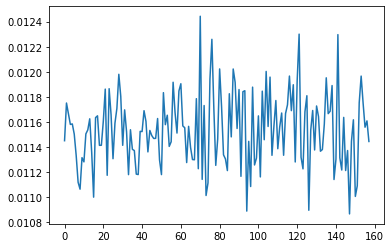

157ch 24 out of 32: loss 0.011444611474871635

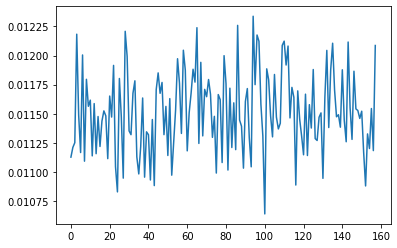

157ch 25 out of 32: loss 0.01208648644387722

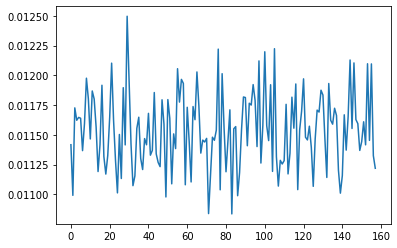

157ch 26 out of 32: loss 0.011218646541237831

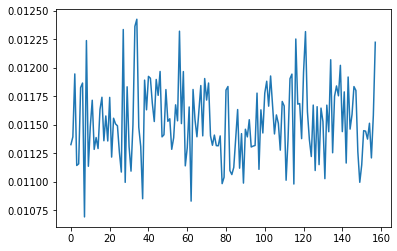

157ch 27 out of 32: loss 0.012224001809954643

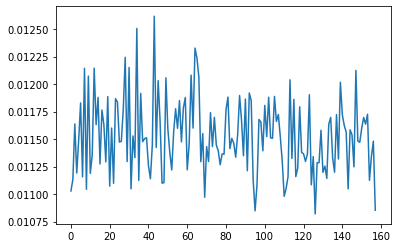

157ch 28 out of 32: loss 0.010852613486349583

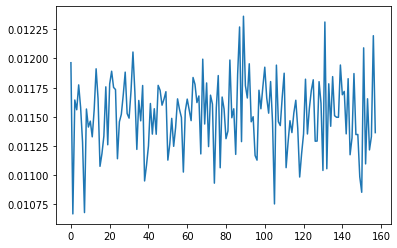

157ch 29 out of 32: loss 0.011365259066224098

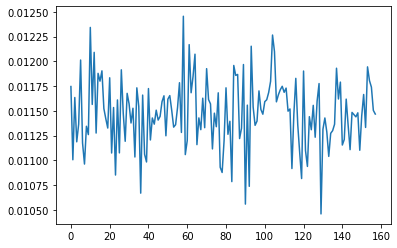

157ch 30 out of 32: loss 0.011467867530882359

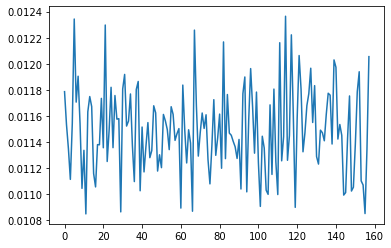

157ch 31 out of 32: loss 0.012054326944053173

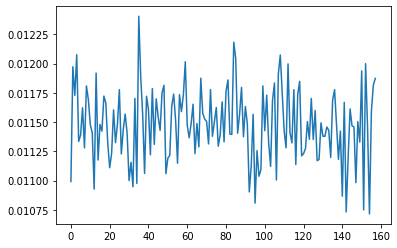

157ch 32 out of 32: loss 0.011873487383127213

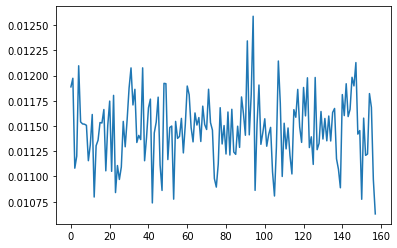

/home/lorenzo/catkin_ws/data/trained_nets/gallery_detection_nets/laserscan_image_based/lets_get_chonky_2_losss_MSELoss_lr_0.0001_N_32_small
type: lets_get_chonky_2, loss: MSELoss, lr: 5e-05
157ch 1 out of 32: loss 1

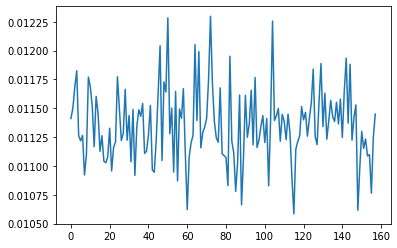

157ch 2 out of 32: loss 0.011449502781033516

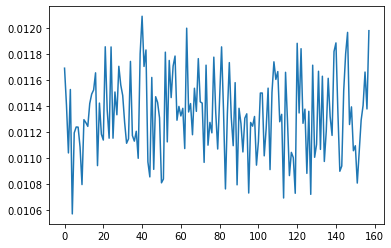

157ch 3 out of 32: loss 0.01197745930403471

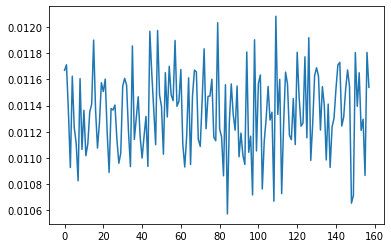

157ch 4 out of 32: loss 0.011539079248905182

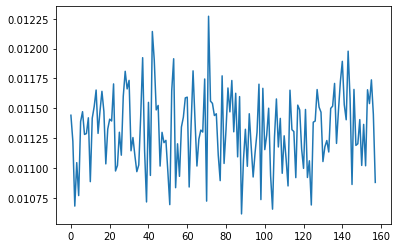

157ch 5 out of 32: loss 0.010880162008106709

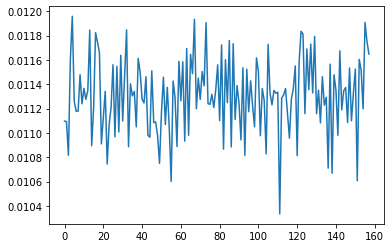

157ch 6 out of 32: loss 0.011648491956293583

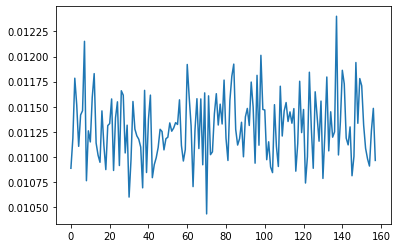

157ch 7 out of 32: loss 0.010966164059937

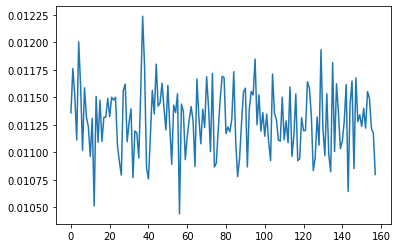

157ch 8 out of 32: loss 0.01079931017011404

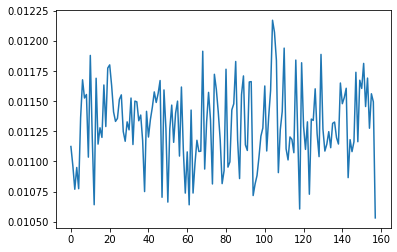

157ch 9 out of 32: loss 0.010531052947044373

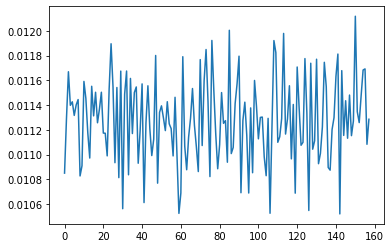

157ch 10 out of 32: loss 0.011285492219030857

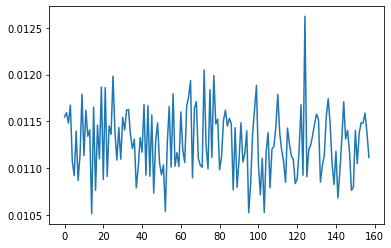

157ch 11 out of 32: loss 0.011115306988358498

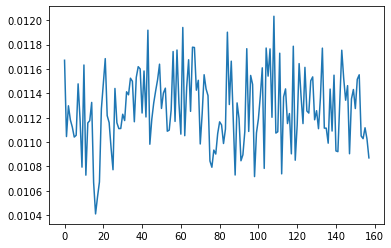

157ch 12 out of 32: loss 0.010869783349335194

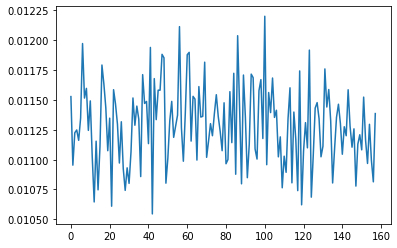

157ch 13 out of 32: loss 0.011384698562324047

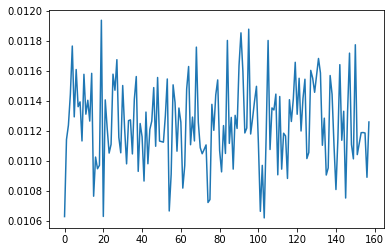

157ch 14 out of 32: loss 0.01126064546406269

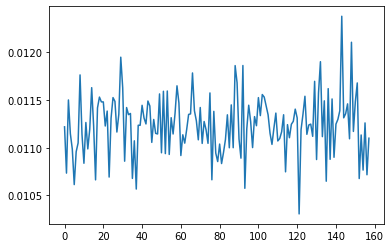

157ch 15 out of 32: loss 0.01110003236681223

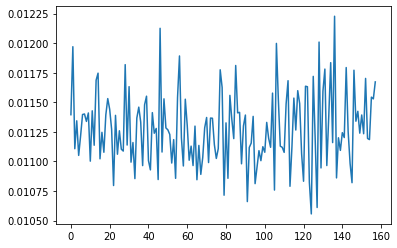

157ch 16 out of 32: loss 0.011672599241137505

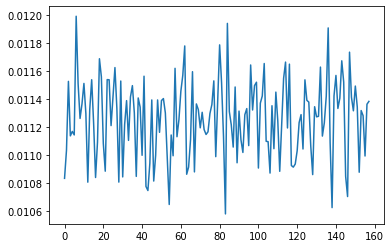

157ch 17 out of 32: loss 0.011383724398911

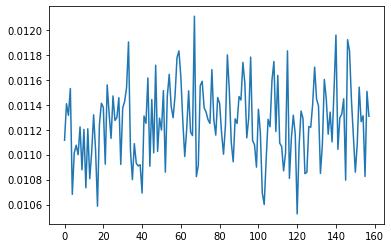

157ch 18 out of 32: loss 0.011307226493954659

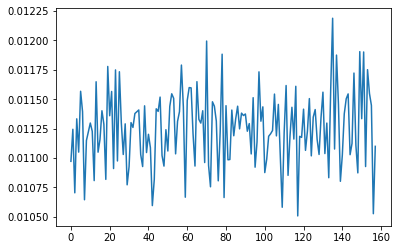

157ch 19 out of 32: loss 0.011099154129624367

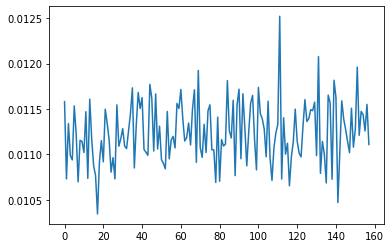

157ch 20 out of 32: loss 0.011109253391623497

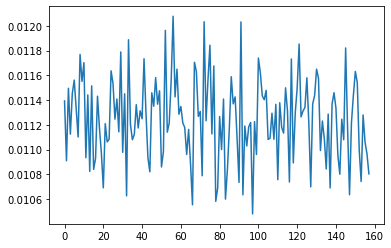

157ch 21 out of 32: loss 0.010804674588143826

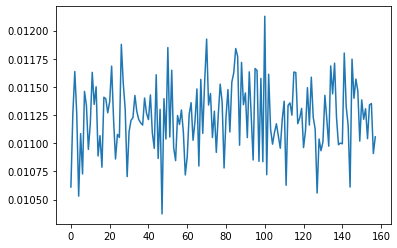

157ch 22 out of 32: loss 0.011057364754378796

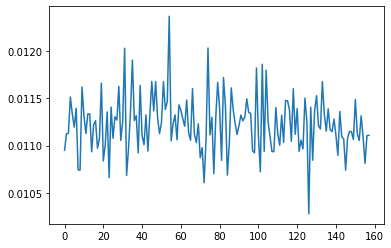

157ch 23 out of 32: loss 0.011108076199889183

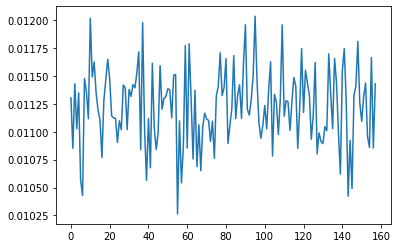

157ch 24 out of 32: loss 0.011429985985159874

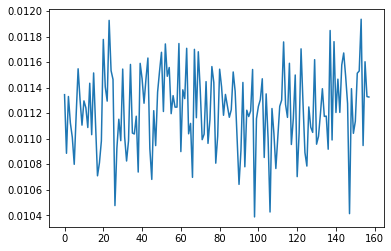

157ch 25 out of 32: loss 0.01132613979279995

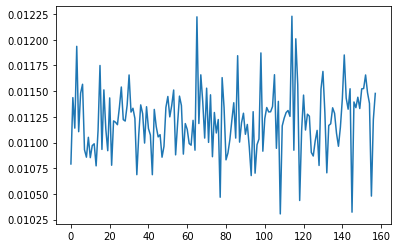

157ch 26 out of 32: loss 0.011478250846266747

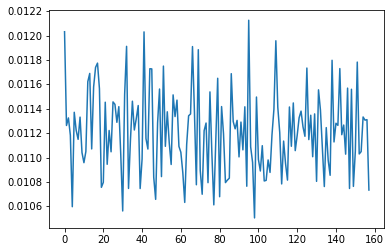

157ch 27 out of 32: loss 0.010733838193118572

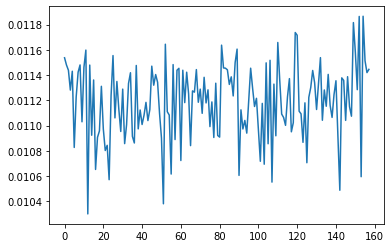

157ch 28 out of 32: loss 0.01144519355148077

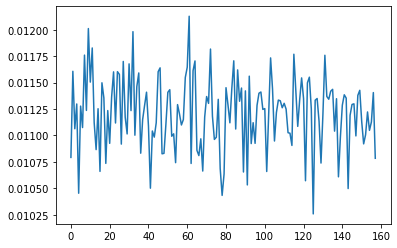

157ch 29 out of 32: loss 0.010783684439957142

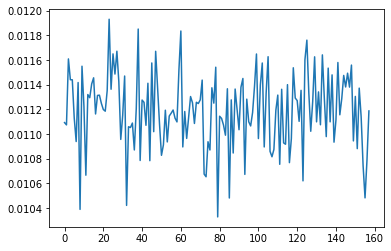

157ch 30 out of 32: loss 0.011187400668859482

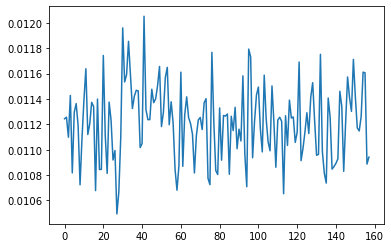

157ch 31 out of 32: loss 0.01094138715416193

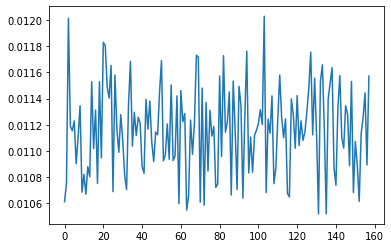

157ch 32 out of 32: loss 0.011572624556720257

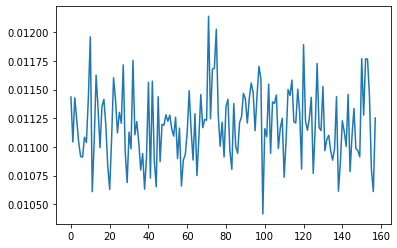

/home/lorenzo/catkin_ws/data/trained_nets/gallery_detection_nets/laserscan_image_based/lets_get_chonky_2_losss_MSELoss_lr_5e-05_N_32_small
type: lets_get_chonky_2, loss: MSELoss, lr: 1e-05
157ch 1 out of 32: loss 1

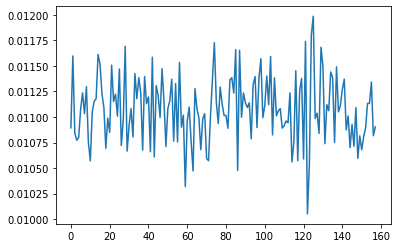

157ch 2 out of 32: loss 0.010902329348027706

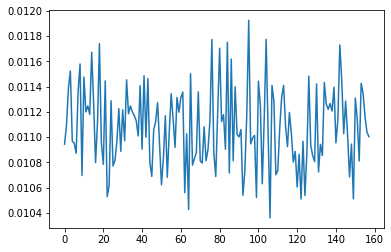

157ch 3 out of 32: loss 0.011004366911947727

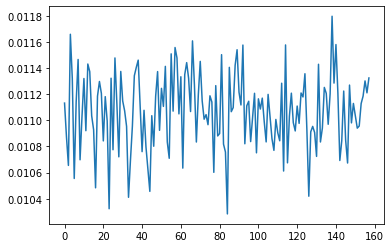

157ch 4 out of 32: loss 0.011324647814035416

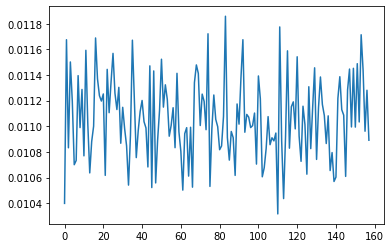

157ch 5 out of 32: loss 0.010891036130487919

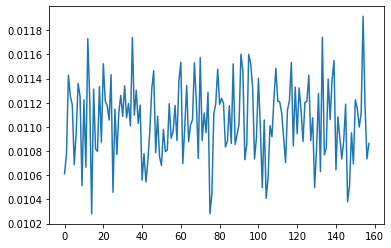

157ch 6 out of 32: loss 0.010862567462027073

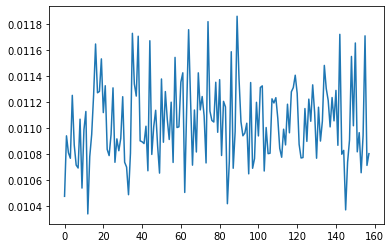

157ch 7 out of 32: loss 0.010803181678056717

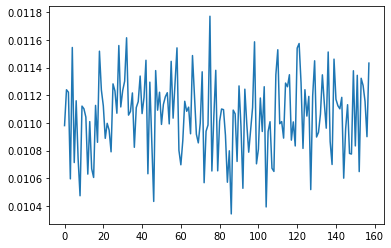

157ch 8 out of 32: loss 0.011432621628046036

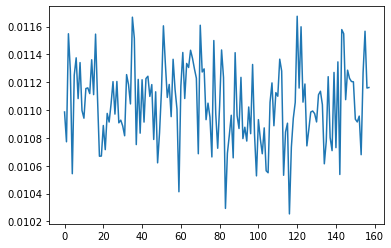

157ch 9 out of 32: loss 0.011161871254444122

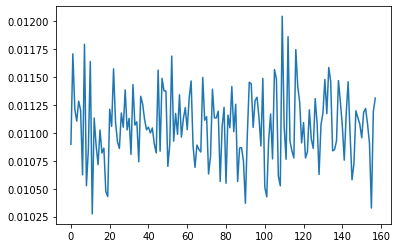

157ch 10 out of 32: loss 0.011311298236250877

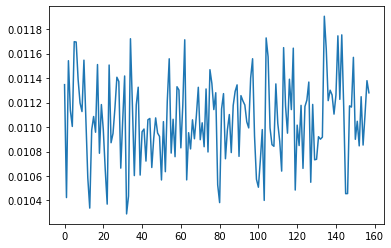

157ch 11 out of 32: loss 0.011279536411166191

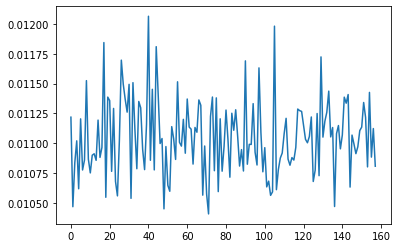

157ch 12 out of 32: loss 0.010807047598063946

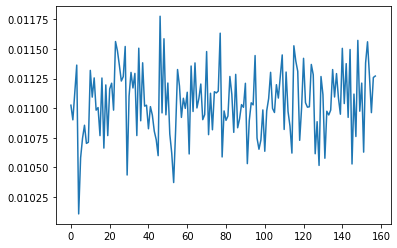

157ch 13 out of 32: loss 0.011272037401795387

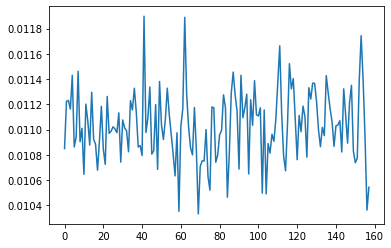

157ch 14 out of 32: loss 0.01054371427744627

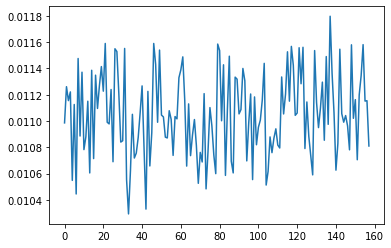

157ch 15 out of 32: loss 0.010809746570885181

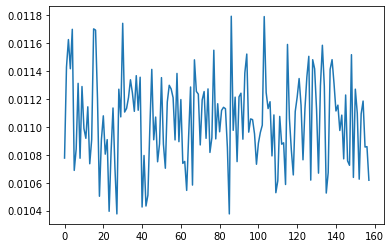

157ch 16 out of 32: loss 0.010617689229547977

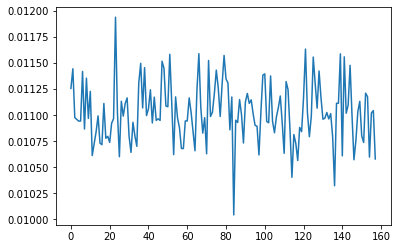

157ch 17 out of 32: loss 0.010576850734651089

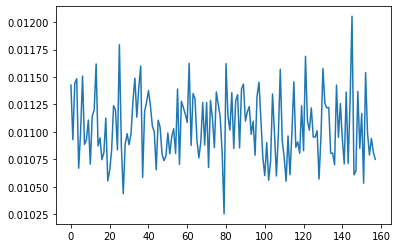

157ch 18 out of 32: loss 0.010749968700110912

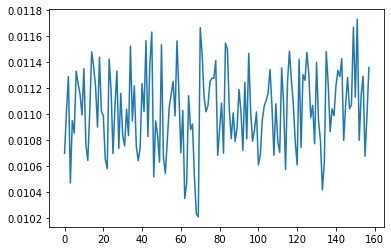

157ch 19 out of 32: loss 0.011359852738678455

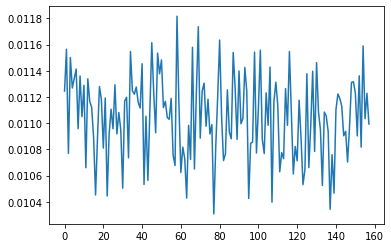

157ch 20 out of 32: loss 0.010993360541760921

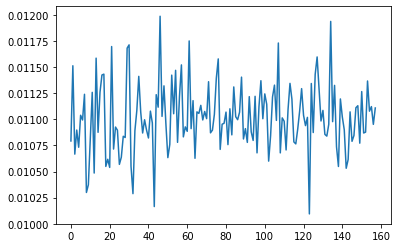

157ch 21 out of 32: loss 0.011109236627817154

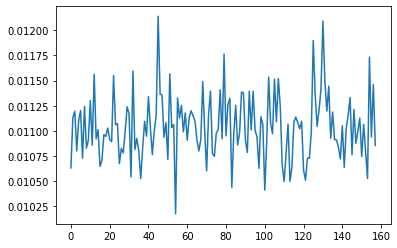

157ch 22 out of 32: loss 0.010855691507458687

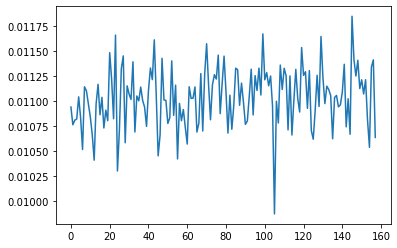

157ch 23 out of 32: loss 0.01063968613743782

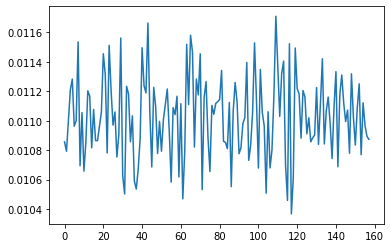

157ch 24 out of 32: loss 0.010873260907828808

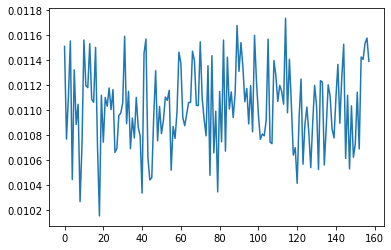

157ch 25 out of 32: loss 0.011391254141926765

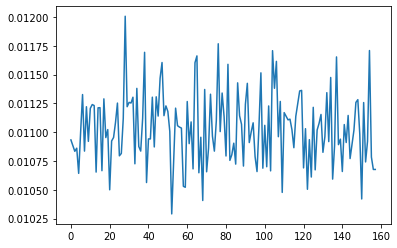

157ch 26 out of 32: loss 0.010677040554583073

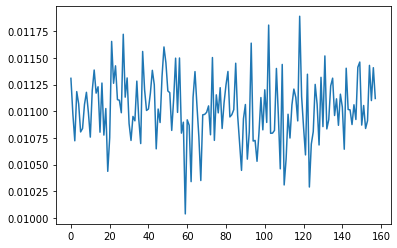

157ch 27 out of 32: loss 0.011119546368718147

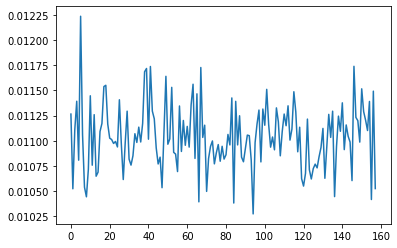

157ch 28 out of 32: loss 0.010525373741984367

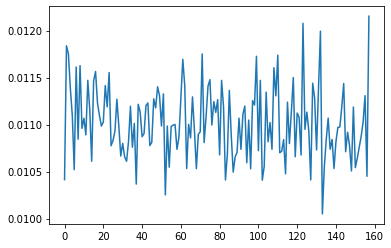

157ch 29 out of 32: loss 0.012151706963777542

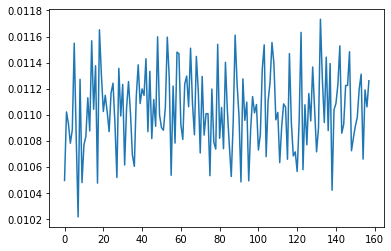

157ch 30 out of 32: loss 0.011260438710451126

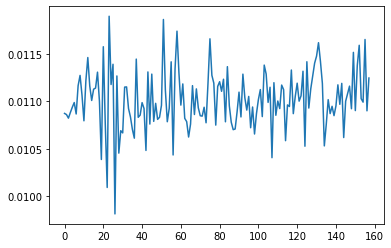

157ch 31 out of 32: loss 0.011244560591876507

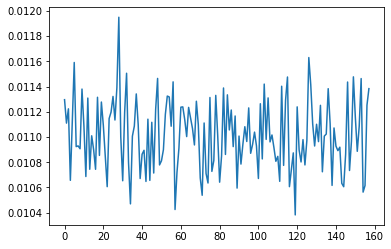

157ch 32 out of 32: loss 0.011383346281945705

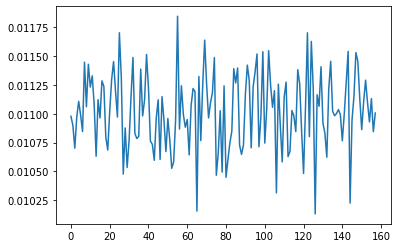

/home/lorenzo/catkin_ws/data/trained_nets/gallery_detection_nets/laserscan_image_based/lets_get_chonky_2_losss_MSELoss_lr_1e-05_N_32_small


In [50]:
net = NET()
torch.cuda.empty_cache()
LR = [0.0002, 0.0001, 0.00005, 0.00001]
BATCH_SIZE = 512
N_EPOCHS = 32

train_dataloader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=5)    
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=5)    


criterion = nn.MSELoss()
if UPDATE_MODEL:
    net.load_state_dict(torch.load(PATH_TO_MODEL))
net = net.to(device).float()
for lr in LR:
    torch.cuda.empty_cache()

    print(
        "type: {}, loss: {}, lr: {}".format(
            NET.__name__, criterion.__class__.__name__, lr
        )
    ) 
    
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=lr,
    )
    loss_hist = basic_train(
        net, train_dataloader,test_dataloader, criterion, optimizer, N_EPOCHS
    )
    NN_PATH = "/home/lorenzo/catkin_ws/data/trained_nets/gallery_detection_nets/laserscan_image_based/{}_losss_{}_lr_{}_N_{}_small".format(
        NET.__name__, criterion.__class__.__name__, lr, N_EPOCHS
    )
    print(NN_PATH)
    torch.save(net.state_dict(), NN_PATH)


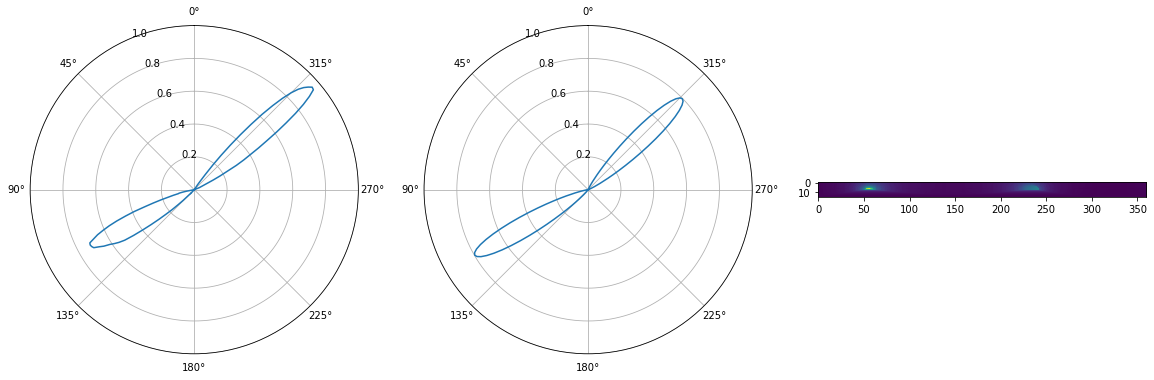

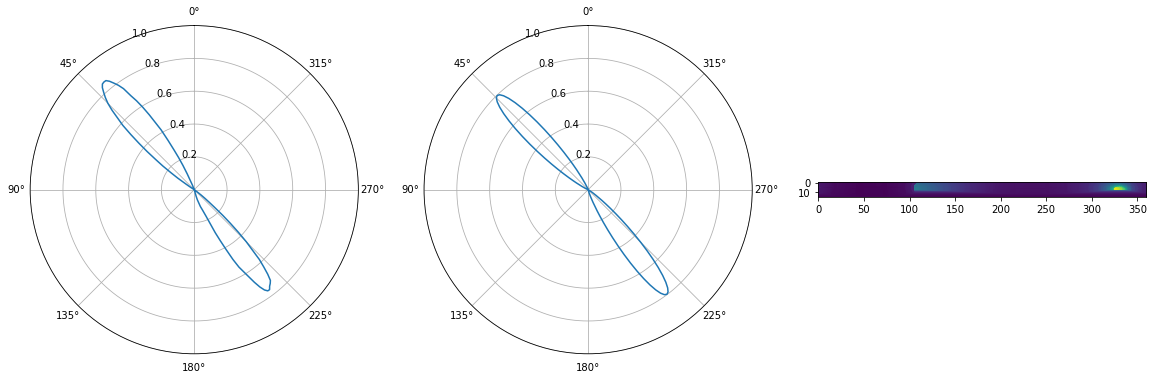

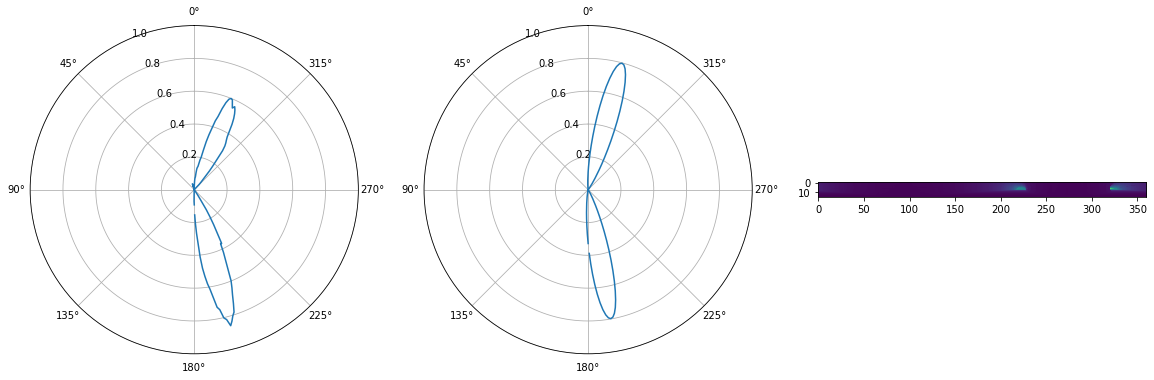

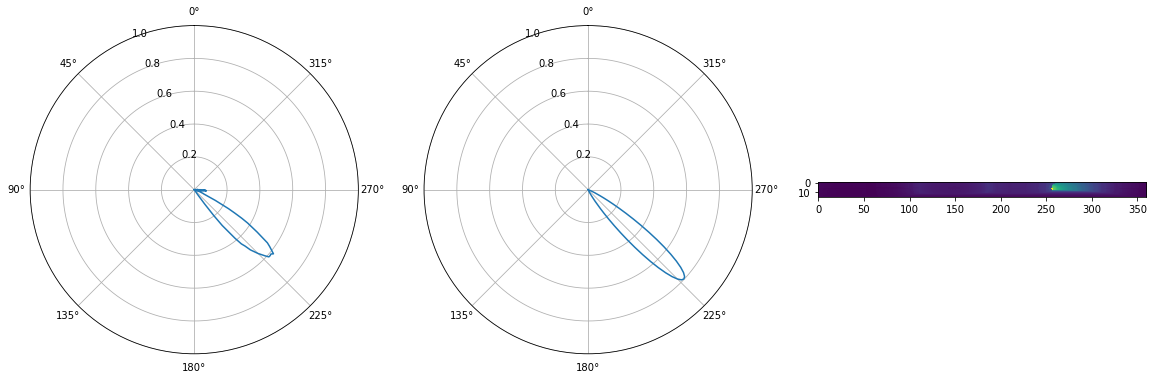

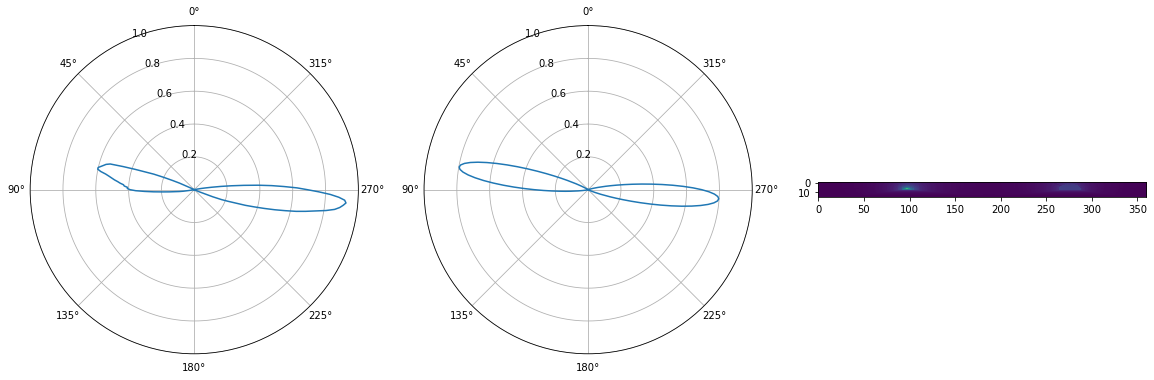

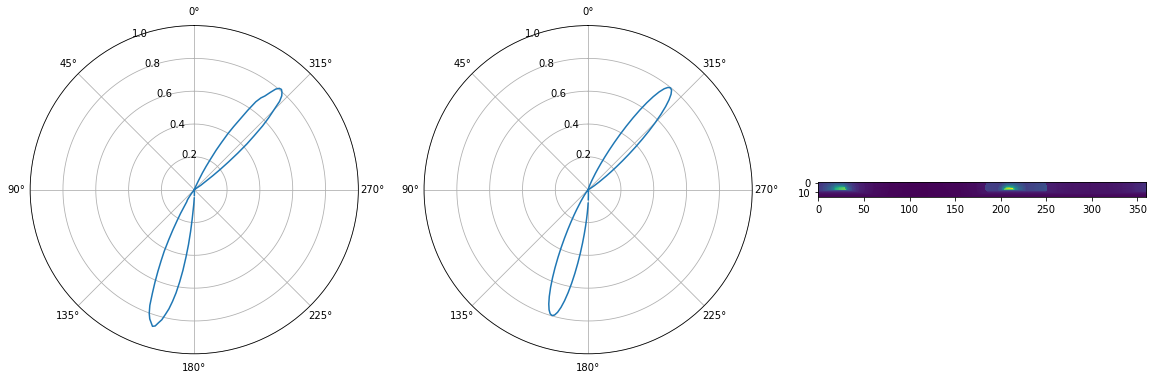

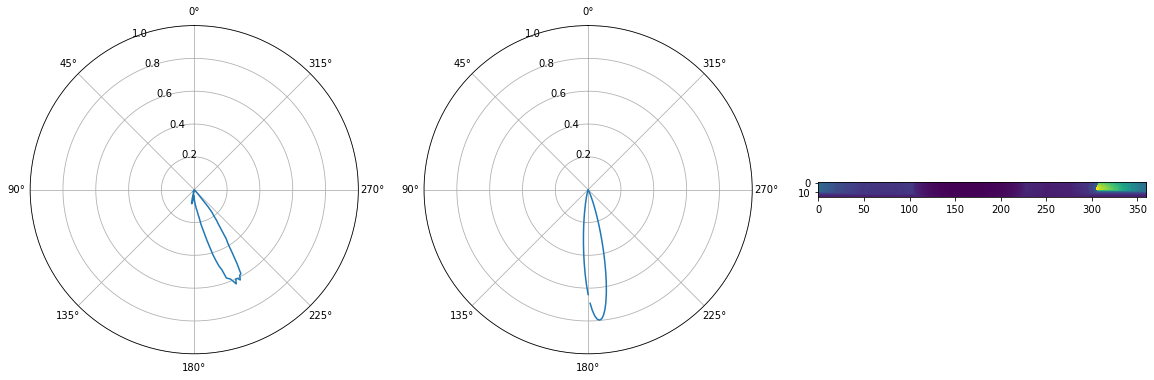

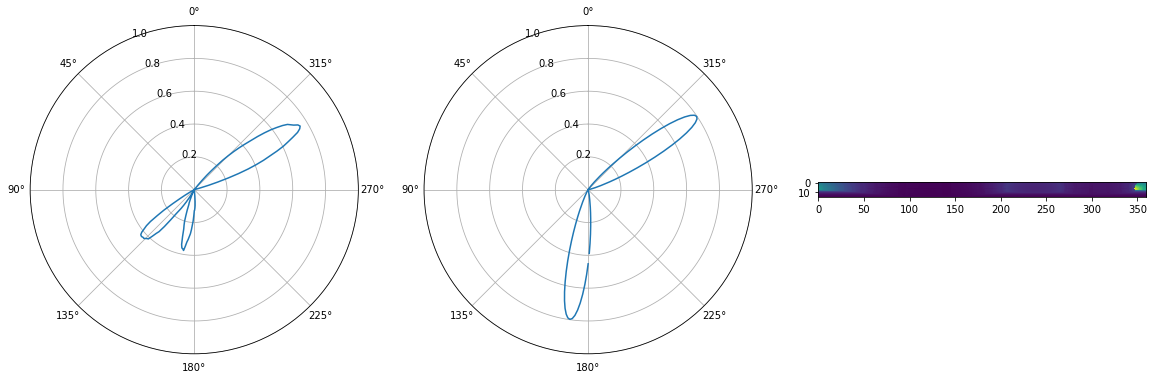

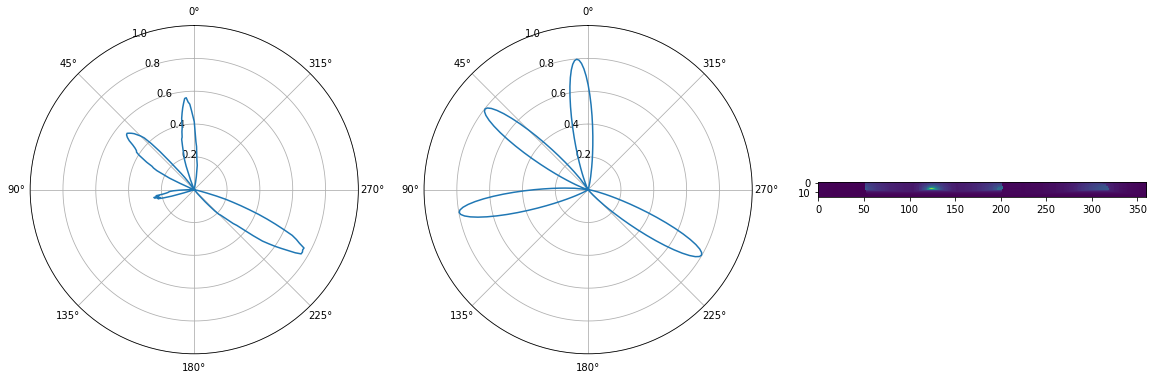

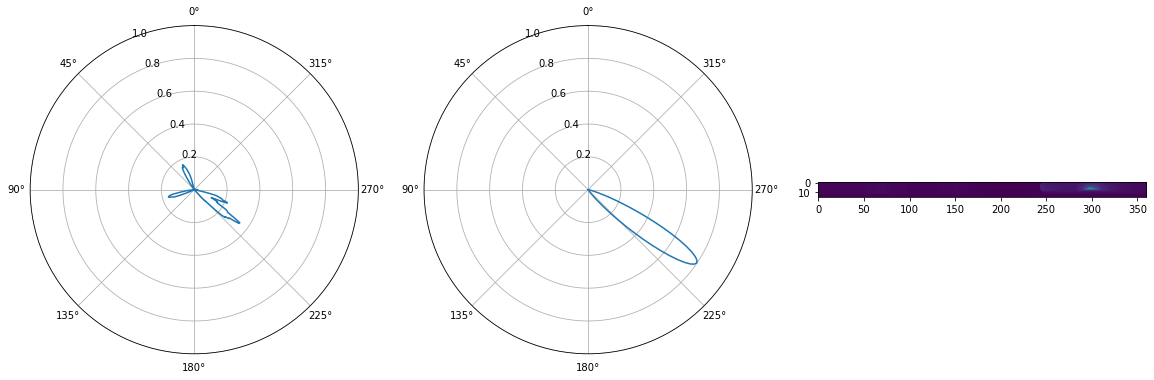

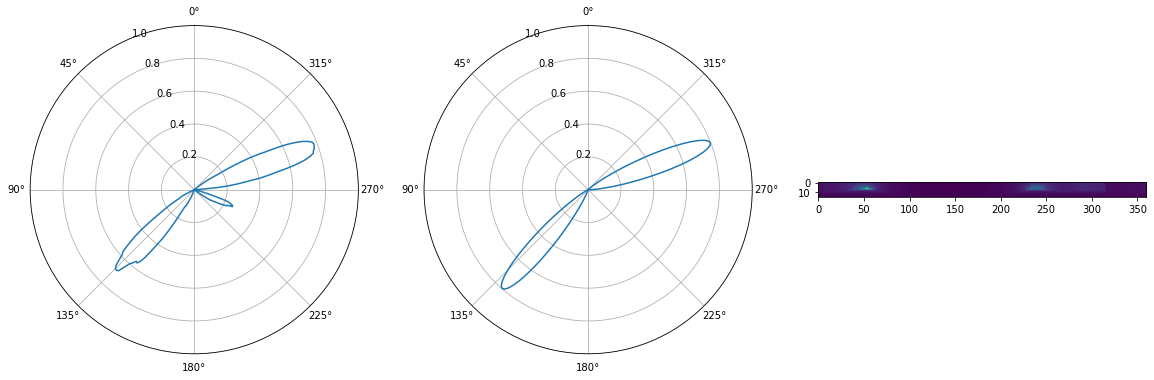

In [ ]:

if 0:
    NN_PATH = "/home/lorenzo/catkin_ws/data/trained_nets/gallery_detection_nets/laserscan_image_based/gallery_detector_v3_v2_losss_MSELoss_lr_0.001_N_124_small"
    net = gallery_detector_v3_v2()
    net = net.to(device).float()
    net.load_state_dict(torch.load(NN_PATH))
    
else:
    net.load_state_dict(torch.load(NN_PATH))
    net = net.to(device).float()

import numpy as np 
theta = np.arange(180, -180, -1) / 180 * np.math.pi
a = 0
dataset.do_augment=False
for i in data_utils.DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True):
    a+=1
    if not a % 8000:
        image = i[0]
        image /= torch.max(image)
        data = net(image.to(device))
        data = data.detach().cpu().numpy().flatten()

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1,polar=True)
        plt.plot(theta, data)
        plt.gca().set_theta_zero_location("N")
        plt.gca().set_rlim(0,1)
        plt.subplot(1,3,2,polar=True)
        plt.plot(theta, i[1].cpu().numpy().flatten())
        plt.gca().set_theta_zero_location("N")
        plt.gca().set_rlim(0,1)
        plt.subplot(1,3,3)
        plt.imshow(torch.squeeze(image))

        plt.show()
        
    